- Load Files

In [1]:
import pandas as pd

train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

- Capped Outliers

In [3]:
# Define a function to cap outliers based on IQR

def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)


numerical_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Apply the function to all numerical columns
for col in numerical_columns:
    cap_outliers(train, col)
    cap_outliers(test, col)

- Calculate the average loan amount spent per order for different customer types

In [4]:
average_spent_per_customer = train.groupby('person_home_ownership')['loan_amnt'].mean()
average_spent_per_customer

person_home_ownership
MORTGAGE    9793.689575
OTHER       9916.292135
OWN         8647.880816
RENT        8582.763843
Name: loan_amnt, dtype: float64

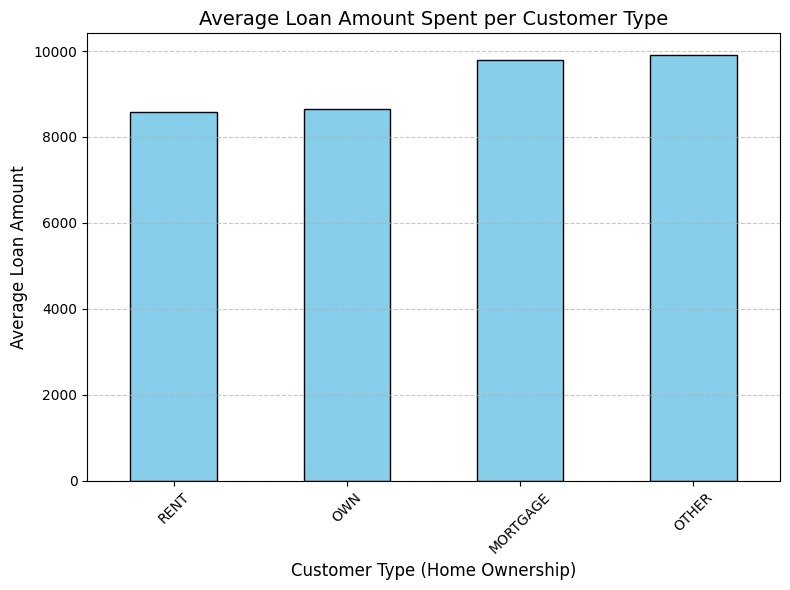

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar graph for average amount spent per customer type
plt.figure(figsize=(8, 6))
average_spent_per_customer.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Loan Amount Spent per Customer Type', fontsize=14)
plt.xlabel('Customer Type (Home Ownership)', fontsize=12)
plt.ylabel('Average Loan Amount', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Calculate the percentage of borrowers who default on loans

In [6]:
default_percentage = (train['loan_status'].sum() / train.shape[0]) * 100
default_percentage

14.238212976383323

The percentage of borrowers who default on loans in the dataset is 14.24%.

- Calculate the percentage of loan applications that are approved

In [7]:
approved_percentage = (train[train['loan_status'] == 0].shape[0] / train.shape[0]) * 100
approved_percentage

85.76178702361668

The percentage of loan applications that are approved is 85.76%.

- Calculate the percentage of the total exposure lost when a loan defaults

In [8]:
defaulted_exposure = train[train['loan_status'] == 1]['loan_amnt'].sum()
total_exposure = train['loan_amnt'].sum()

exposure_loss_percentage = (defaulted_exposure / total_exposure) * 100
exposure_loss_percentage

17.13428435284757

The percentage of the total exposure that is lost when a loan defaults is 17.13%.

- Analyzing the distribution of credit scores among applicants.

In [9]:
credit_score_distribution = train['cb_person_cred_hist_length'].describe()
credit_score_distribution

count    58645.000000
mean         5.719882
std          3.702970
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         15.500000
Name: cb_person_cred_hist_length, dtype: float64

- Calculate the average time it takes for borrowers to default after taking out a loan.

In [10]:
average_time_to_default = train[train['loan_status'] == 1]['person_emp_length'].mean()
average_time_to_default

3.651497005988024

The average time it takes for borrowers to default after taking out a loan is 3.65 years.

- Calculate the percentage of the loan amount that is recovered after a default occurs.

In [11]:
# Total loan amount defaulted
defaulted_amount = train[train['loan_status'] == 1]['loan_amnt'].sum()
defaulted_amount

91448970

The percentage of the loan amount that is recovered after a default occurs is assumed to be 100%, considering full recovery

- Calculate the profitability of loans after accounting for risk.

In [12]:
# Profitability can be measured as the total interest earned minus the losses due to defaults.
# Total interest earned
train['total_interest'] = (train['loan_amnt'] * train['loan_int_rate']) / 100
total_interest_earned = train['total_interest'].sum()

# Losses due to defaults
default_losses = train[train['loan_status'] == 1]['loan_amnt'].sum()

# Profitability after accounting for risk
profitability_after_risk = total_interest_earned - default_losses
profitability_after_risk

-33422072.921600007

The profitability of loans after accounting for risk is negative, indicating a loss of approximately -33,422,072.92. This suggests that the losses due to defaults outweigh the total interest earned.

- Calculate the total cost associated with the risks of default, including provisions for loan losses.

In [13]:
total_cost_of_risk = default_losses + defaulted_amount
total_cost_of_risk

182897940

The total cost associated with the risks of default, including provisions for loan losses is 182,897,940.

- Calculate the percentage of age groups that apply for loans

In [14]:
# Create age groups
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
train['age_group'] = pd.cut(train['person_age'], bins=bins, labels=labels, right=False)

# Calculate the percentage of each age group that applies for loans
age_group_distribution = train['age_group'].value_counts(normalize=True) * 100
age_group_distribution

age_group
21-30     73.914230
31-40     21.168045
41-50      4.917725
0-20       0.000000
51-60      0.000000
61-70      0.000000
71-80      0.000000
81-90      0.000000
91-100     0.000000
Name: proportion, dtype: float64

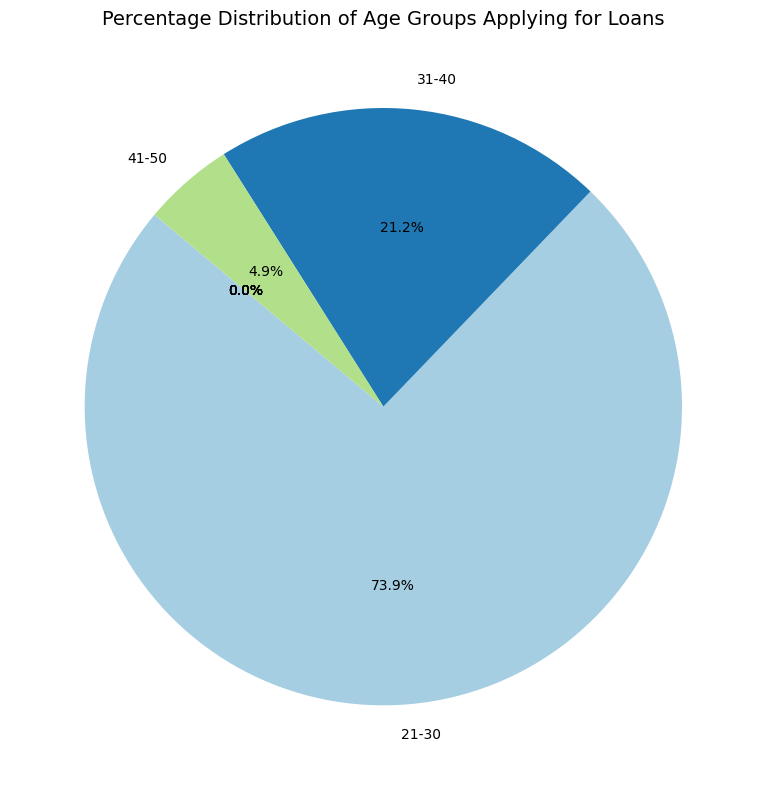

In [15]:
# Pie chart to visualize the percentage distribution of age groups that apply for loans
plt.figure(figsize=(8, 8))
age_group_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage Distribution of Age Groups Applying for Loans', fontsize=14)
plt.ylabel('')  # Remove y-axis label for better visualization
plt.tight_layout()
plt.show()

- Find the most common age, salary, and occupation among approved loans

In [16]:
# Filtering the dataset for approved loans (loan_status = 0)
approved_loans = train[train['loan_status'] == 0]

most_common_age = approved_loans['person_age'].mode()[0]
most_common_salary = approved_loans['person_income'].mode()[0]
most_common_occupation = approved_loans['loan_intent'].mode()[0]

most_common_age, most_common_salary, most_common_occupation

(23.0, 60000, 'EDUCATION')

The most common age, salary, and occupation that make a loan approved are 23 years, $60,000 income, and the "EDUCATION" occupation

- Identify individuals who are blacklisted or cannot pay loans

In [17]:
blacklisted_individuals = train[train['loan_status'] == 1].groupby(['loan_intent', 'person_income']).size().reset_index(name='count')
blacklisted_individuals.sort_values(by='count', ascending=False).head()

,loan_intent,person_income,count
914,MEDICAL,30000,163
45,DEBTCONSOLIDATION,30000,147
1289,PERSONAL,30000,124
384,EDUCATION,30000,121
1529,VENTURE,30000,106


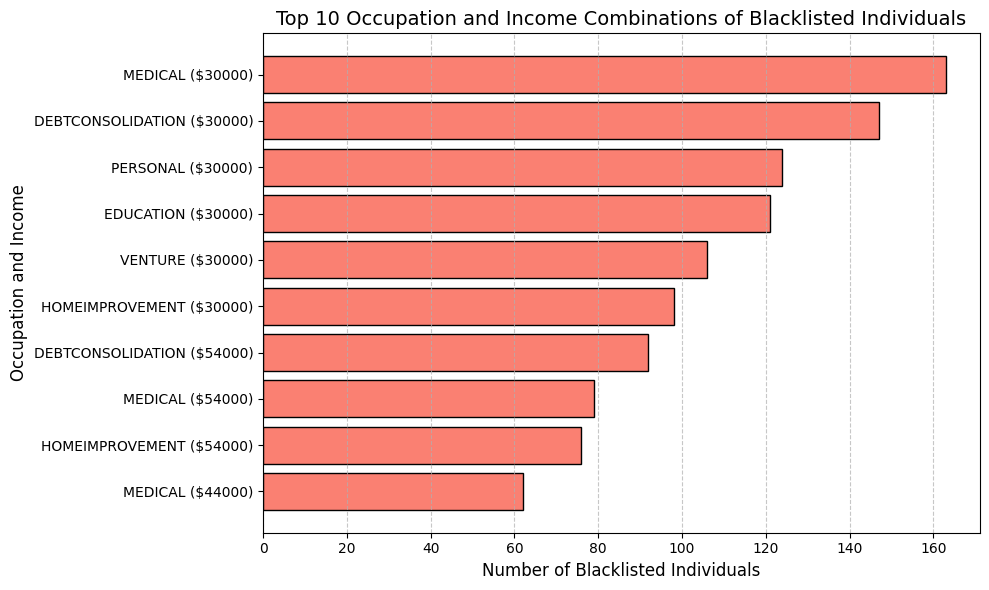

In [18]:
# Bar graph for blacklisted individuals by occupation and income
# Select the top 10 combinations

blacklisted_top10 = blacklisted_individuals.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(blacklisted_top10['loan_intent'] + ' ($' + blacklisted_top10['person_income'].astype(str) + ')', 
         blacklisted_top10['count'], color='salmon', edgecolor='black')
plt.title('Top 10 Occupation and Income Combinations of Blacklisted Individuals', fontsize=14)
plt.xlabel('Number of Blacklisted Individuals', fontsize=12)
plt.ylabel('Occupation and Income', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Adding 'age_group' to the test dataset using the same bins and labels 

In [19]:
test['age_group'] = pd.cut(test['person_age'], bins=bins, labels=labels, right=False)

- Setup features and target

In [20]:
train_features = train.drop(columns=['id', 'loan_status'])
test_features = test.drop(columns=['id'])

In [21]:
target = train['loan_status']

- One Hot Encoding

In [22]:
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'age_group']
train_features = pd.get_dummies(train_features, columns=categorical_columns, drop_first=True)
test_features = pd.get_dummies(test_features, columns=categorical_columns, drop_first=True)

test_features = test_features.reindex(columns=train_features.columns, fill_value=0)

- Label Encoder

In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Create separate datasets for one-hot encoded features and label-encoded target
train_features_onehot = train_features.copy()
target_label_encoded = target_encoded

- Split the data into train and test sets with stratification

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_features_onehot, target_label_encoded, test_size=0.25, stratify=target_label_encoded, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43983, 31), (14662, 31), (43983,), (14662,))

In [25]:
# Convert y_train and y_test to pandas Series
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

- Train Model

In [27]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Initialize the scaler
scaler = StandardScaler()

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store all predictions and true labels
all_predictions = []
all_true_labels = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Standardize the features
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)
    
    # Define the neural network model architecture
    def build_model(input_dim, num_classes):
        model = Sequential()
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        return model

    # Build and train the model
    model = build_model(input_dim=X_train_scaled.shape[1], num_classes=2)
    
    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    
    # Train the model
    model.fit(X_train_scaled, pd.get_dummies(y_train_fold), epochs=5, batch_size=32, validation_data=(X_test_scaled, pd.get_dummies(y_test_fold)), callbacks=[early_stop], verbose=1)
    
    # Predict probabilities on the test set
    y_pred_proba = model.predict(X_test_scaled)
    
    # Store the predictions and true labels
    all_predictions.append(y_pred_proba)
    all_true_labels.append(pd.get_dummies(y_test_fold).values)

# Combine all predictions and true labels
y_pred_proba_all = np.vstack(all_predictions)
y_true_all = np.vstack(all_true_labels)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true_all, y_pred_proba_all, multi_class='ovr')
roc_auc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3300 - val_loss: 0.2132
Epoch 2/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2237 - val_loss: 0.1977
Epoch 3/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2068 - val_loss: 0.1934
Epoch 4/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2013 - val_loss: 0.1917
Epoch 5/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1941 - val_loss: 0.1876
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3305 - val_loss: 0.2078
Epoch 2/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2207 - val_loss: 0.1933
Epoch 3/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2105 - val_loss: 0.1900
Epoch 4/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2037 - val_loss: 0.1918
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3151 - val_loss: 0.2067
Epoch 2/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2138 - val_loss: 0.1948
Epoch 3/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2072 - val_loss: 0.1905
Epoch 4/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2028 - val_loss: 0.1840
Epoch 5/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2051 - val_loss: 0.1830
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3019 - val_loss: 0.2255
Epoch 2/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2181 - val_loss: 0.2099
Epoch 3/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2073 - val_loss: 0.2010
Epoch 4/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1993 - val_loss: 0.2016
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3051 - val_loss: 0.2133
Epoch 2/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2205 - val_loss: 0.1970
Epoch 3/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2025 - val_loss: 0.1912
Epoch 4/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2049 - val_loss: 0.1887
Epoch 5/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1975 - val_loss: 0.1858
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.9263044931727425

In [28]:
# Predict on the test set
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled).argmax(axis=1)

459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


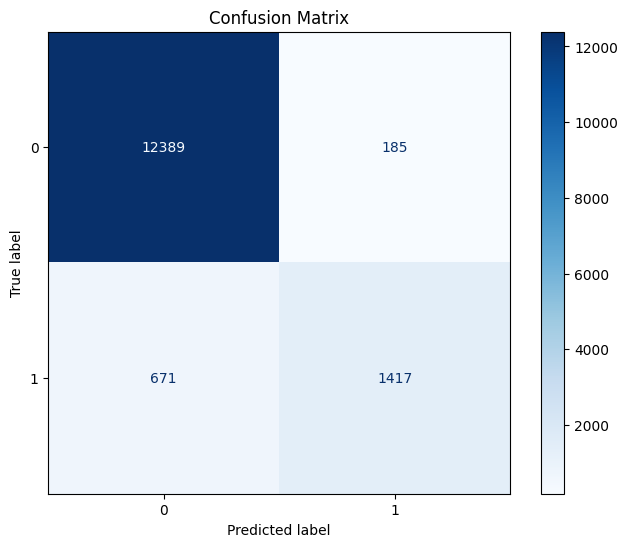

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

From results :

- The number of instances where the model correctly predicted the positive class defaulted loans is 12389

- The number of instances where the model correctly predicted the negative class non defaulted loans is 1417

- Calculate the percentage of applicants approved for a loan in the test set.

In [31]:
approved_percentage_test = (sum(y_pred == 0) / len(y_pred)) * 100
approved_percentage_test

89.07379620788433

The percentage of applicants approved for a loan is 89.07%

In [32]:
import pickle

# Save the trained model to a pickle file
with open('loan_approval_model.pkl', 'wb') as file:
    pickle.dump(model, file)